## Forecast Evaluations

In [2]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/Miles_Traveled.csv

--2020-10-05 10:23:35--  https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/Miles_Traveled.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.86
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10603 (10K) [application/vnd.ms-excel]
Saving to: ‘Miles_Traveled.csv’

Miles_Traveled.csv  100%[===================>]  10.35K  --.-KB/s    in 0s      

2020-10-05 10:23:36 (134 MB/s) - ‘Miles_Traveled.csv’ saved [10603/10603]



### Classic Train/Test Split

In [3]:
import pandas as pd
from fbprophet import Prophet
%matplotlib inline

In [4]:
df = pd.read_csv('Miles_Traveled.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


* NO DATETIME! Need to be converted

In [9]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [10]:
df.columns = ['ds','y']

In [11]:
# YOU CAN SAFELY IGNORE THIS COPY WARNING
# CHECK THE DOCS LINK FOR MORE INFO ON THIS COPY WARNING
df['ds'] = pd.to_datetime(df['ds'])

In [12]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


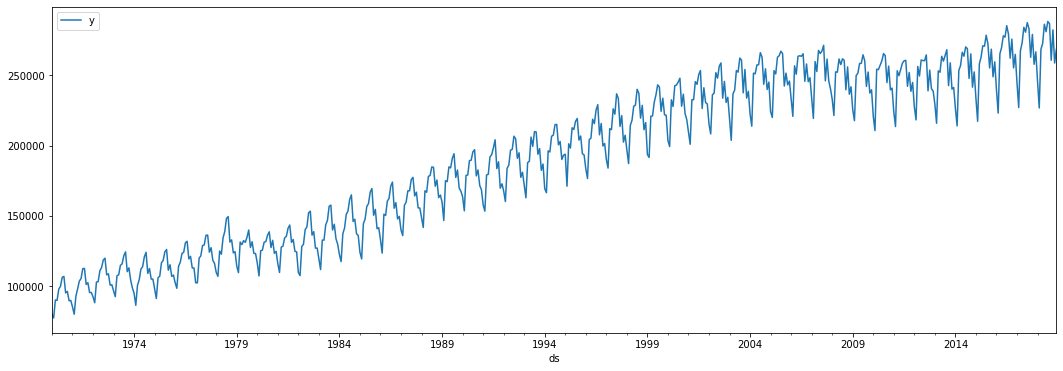

In [14]:
df.plot(x='ds',y='y',figsize=(18,6));

In [17]:
## Prediction of 12 months= 1Y

In [18]:
len(df)

588

In [19]:
len(df) - 12

576

In [20]:
588-12

576

In [21]:
train = df.iloc[:576]
test = df.iloc[576:]

In [22]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=12,freq='MS')
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263457.725002,274705.853543,285679.085035,263391.348431,263491.029741,16443.644514,16443.644514,16443.644514,16443.644514,16443.644514,16443.644514,0.0,0.0,0.0,279901.369516
584,2018-09-01,263600.413936,256274.384146,267896.981570,263489.335666,263655.541616,-1674.285262,-1674.285262,-1674.285262,-1674.285262,-1674.285262,-1674.285262,0.0,0.0,0.0,261926.128674
585,2018-10-01,263738.500000,263499.424682,274824.945343,263600.949183,263833.654799,5300.999421,5300.999421,5300.999421,5300.999421,5300.999421,5300.999421,0.0,0.0,0.0,269039.499421
586,2018-11-01,263881.188934,250025.403349,261554.509097,263683.210803,264007.952753,-8214.645301,-8214.645301,-8214.645301,-8214.645301,-8214.645301,-8214.645301,0.0,0.0,0.0,255666.543633
587,2018-12-01,264019.274999,251255.183793,262551.347075,263775.410361,264186.444802,-6925.081926,-6925.081926,-6925.081926,-6925.081926,-6925.081926,-6925.081926,0.0,0.0,0.0,257094.193073


In [25]:
test.tail(12)

,ds,y
576,2018-01-01,245695.0
577,2018-02-01,226660.0
578,2018-03-01,268480.0
579,2018-04-01,272475.0
580,2018-05-01,286164.0
581,2018-06-01,280877.0
582,2018-07-01,288145.0
583,2018-08-01,286608.0
584,2018-09-01,260595.0
585,2018-10-01,282174.0


[Info on ax= parameter](https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure)

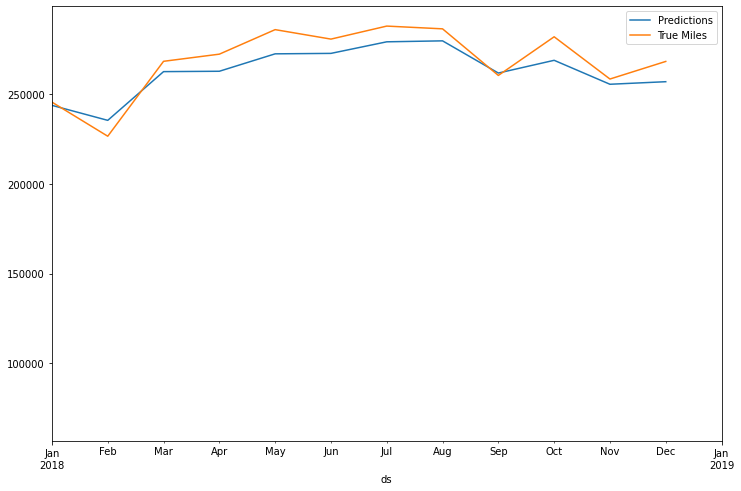

In [27]:
ax = forecast.plot(x='ds',
                   y='yhat',
                   label='Predictions',
                   legend=True,
                   figsize=(12,8))


test.plot(x='ds',
          y='y',
          label='True Miles',
          legend=True,
          xlim=('2018-01-01','2019-01-01'),
          ax=ax);

In [28]:
from statsmodels.tools.eval_measures import rmse

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [29]:
predictions = forecast.iloc[-12:]['yhat']

In [30]:
predictions

576    243890.540695
577    235518.185920
578    262721.044615
579    262926.543476
580    272653.963220
581    272904.801470
582    279365.372083
583    279901.369516
584    261926.128674
585    269039.499421
586    255666.543633
587    257094.193073
Name: yhat, dtype: float64

In [31]:
test['y']

576    245695.0
577    226660.0
578    268480.0
579    272475.0
580    286164.0
581    280877.0
582    288145.0
583    286608.0
584    260595.0
585    282174.0
586    258590.0
587    268413.0
Name: y, dtype: float64

In [32]:
rmse(predictions,test['y'])

8588.50451989775

In [33]:
test.mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



y    268739.666667
dtype: float64

In [34]:
test.describe()

,y
count,12.000000
mean,268739.666667
std,18616.905935
min,226660.000000
25%,260093.750000
50%,270477.500000
75%,283171.500000
max,288145.000000


## Prophet Diagnostics

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

https://facebook.github.io/prophet/docs/diagnostics.html

In [39]:
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [40]:
len(df)

588

In [41]:
len(df)/12

49.0

The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

In [42]:
# PREPARE THE PARAMETER FOR PROPHET
# help(pd.Timedelta)

In [43]:
# Initial 5 years training period
initial = 5 * 365
initial = str(initial) + ' days'
# Fold every 5 years
period = 5 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [44]:
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)

INFO:fbprophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00


In [46]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,108479.087478,107026.834331,109779.918847,102445.0,1976-12-11
1,1977-02-01,102996.111557,101532.551916,104388.034426,102416.0,1976-12-11
2,1977-03-01,118973.318267,117534.271915,120527.297573,119960.0,1976-12-11
3,1977-04-01,120612.923861,119250.429170,121996.300619,121513.0,1976-12-11
4,1977-05-01,127883.031986,126268.198677,129352.269089,128884.0,1976-12-11


In [47]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
103,2017-08-01,273412.916090,267950.160951,278820.060860,283184.0,2016-12-01
104,2017-09-01,255533.787611,249617.313169,261110.750846,262673.0,2016-12-01
105,2017-10-01,262639.269752,257274.060806,268211.591426,278937.0,2016-12-01
106,2017-11-01,249291.849819,243323.574190,255304.821584,257712.0,2016-12-01
107,2017-12-01,250540.244359,244612.597664,256443.110354,266535.0,2016-12-01


In [48]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,52 days,2.430030e+07,4929.533140,4534.578066,0.027790,0.023419,0.4
1,53 days,2.180221e+07,4669.283718,4269.242480,0.025045,0.023419,0.4
2,54 days,1.835927e+07,4284.771500,3749.319270,0.020183,0.022331,0.5
3,55 days,2.318231e+07,4814.801050,4262.593972,0.023194,0.023419,0.4
4,57 days,2.101189e+07,4583.872792,4000.766561,0.021482,0.022331,0.5
...,...,...,...,...,...,...,...
94,360 days,1.833685e+07,4282.155252,3750.317263,0.019550,0.019595,0.5
95,361 days,1.744517e+07,4176.741529,3472.704963,0.018164,0.018940,0.5
96,362 days,3.175299e+07,5634.978870,4397.649029,0.021959,0.024754,0.4
97,364 days,3.001684e+07,5478.762932,4235.776363,0.021356,0.021737,0.5


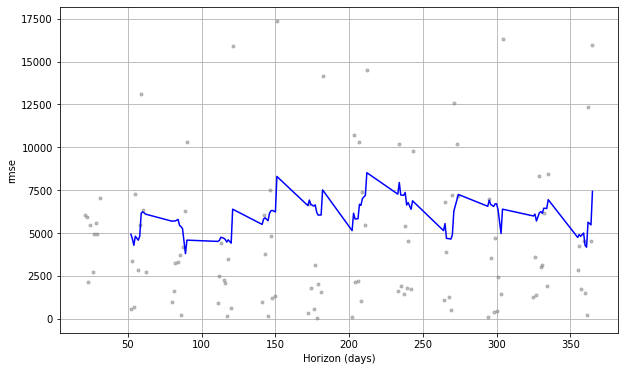

In [50]:
plot_cross_validation_metric(df_cv, metric='rmse');

MAPE is Mean Absolute Percentage Error

https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

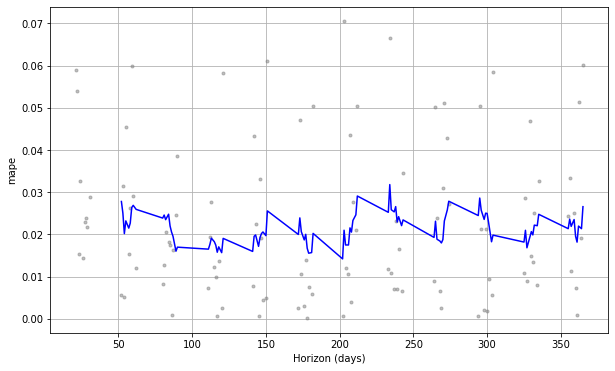

In [51]:
plot_cross_validation_metric(df_cv, metric='mape');